### Importación de librerias


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import glob
from scipy.signal import butter, filtfilt, welch, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma

### Funciones de filtrado

In [ ]:
def filtro_wavelet(signal, wavelet='db4', nivel=6):
    # Nivel bajo para evitar reducción excesiva de tamaño
    max_nivel = min(nivel, pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len))
    coeffs = pywt.wavedec(signal, wavelet, level=max_nivel)
    coeffs[0] = np.zeros_like(coeffs[0])
    sigma_est = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma_est * np.sqrt(2 * np.log(len(signal)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    rec = pywt.waverec(coeffs, wavelet)
    # Asegura que la señal tenga el mismo tamaño
    if len(rec) > len(signal):
        rec = rec[:len(signal)]
    return rec

def filtro_pasabajas(signal, fs=500, cutoff=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, signal)

def filtro_pasaaltas(signal, fs=500, cutoff=0.5, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal)

def filtro_loess(signal, frac=0.01):
    if len(signal) < 2:
        return signal
    result = lowess(signal, np.arange(len(signal)), frac=frac, return_sorted=False)
    if np.any(np.isnan(result)):
        result = np.where(np.isnan(result), signal, result)
    return result

def filtro_nlm_1d(signal, k=7):
    if np.any(np.isnan(signal)):
        signal = np.nan_to_num(signal)
    return np.convolve(signal, np.ones(k)/k, mode='same')



### Funciones de flujo de procesamiento


In [ ]:
def flujo1(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(filtro_pasaaltas(signal, fs), 'db4'), fs)

def flujo2(signal, fs=500):
    return filtro_pasabajas(filtro_wavelet(detrend(signal), 'db4'), fs)

def flujo3(signal, fs=500):
    s1 = filtro_pasabajas(signal, fs)
    s2 = filtro_loess(s1)
    return filtro_nlm_1d(s2)



### Cargar y seleccionar señales

In [ ]:
def cargar_derivacion_II(ruta_archivo):
    data = np.genfromtxt(ruta_archivo, delimiter=',', skip_header=1)
    return data[:, 1]  # Lead II

# Ruta correcta a tu carpeta ECG
ruta_carpeta = 'ECGData/*.csv'

# Cargar los archivos
lista_archivos = glob.glob(ruta_carpeta)
print(f"Se encontraron {len(lista_archivos)} archivos.")

# Selección aleatoria
np.random.seed(42)
archivos_10 = np.random.choice(lista_archivos, size=10, replace=False)



Se encontraron 10646 archivos.


### Procesamiento por flujo y cálculo de fMP

MUSE_20180111_165814_46000.csv - len(f3): 5000, NaNs: 0, min: -190.598048339436, max: 215.24293421264318


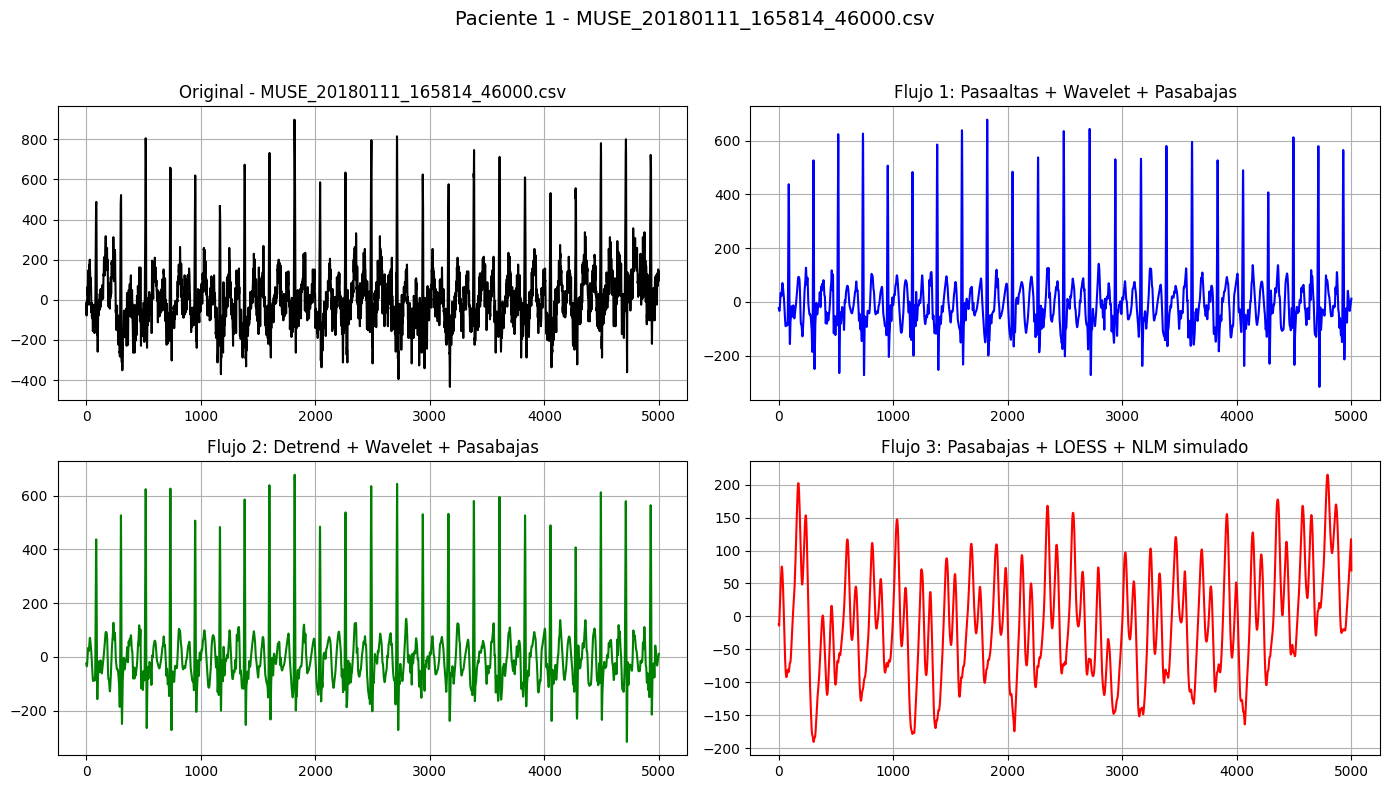

MUSE_20180114_121142_54000.csv - len(f3): 5000, NaNs: 0, min: -96.03455329435297, max: 392.8522533012676


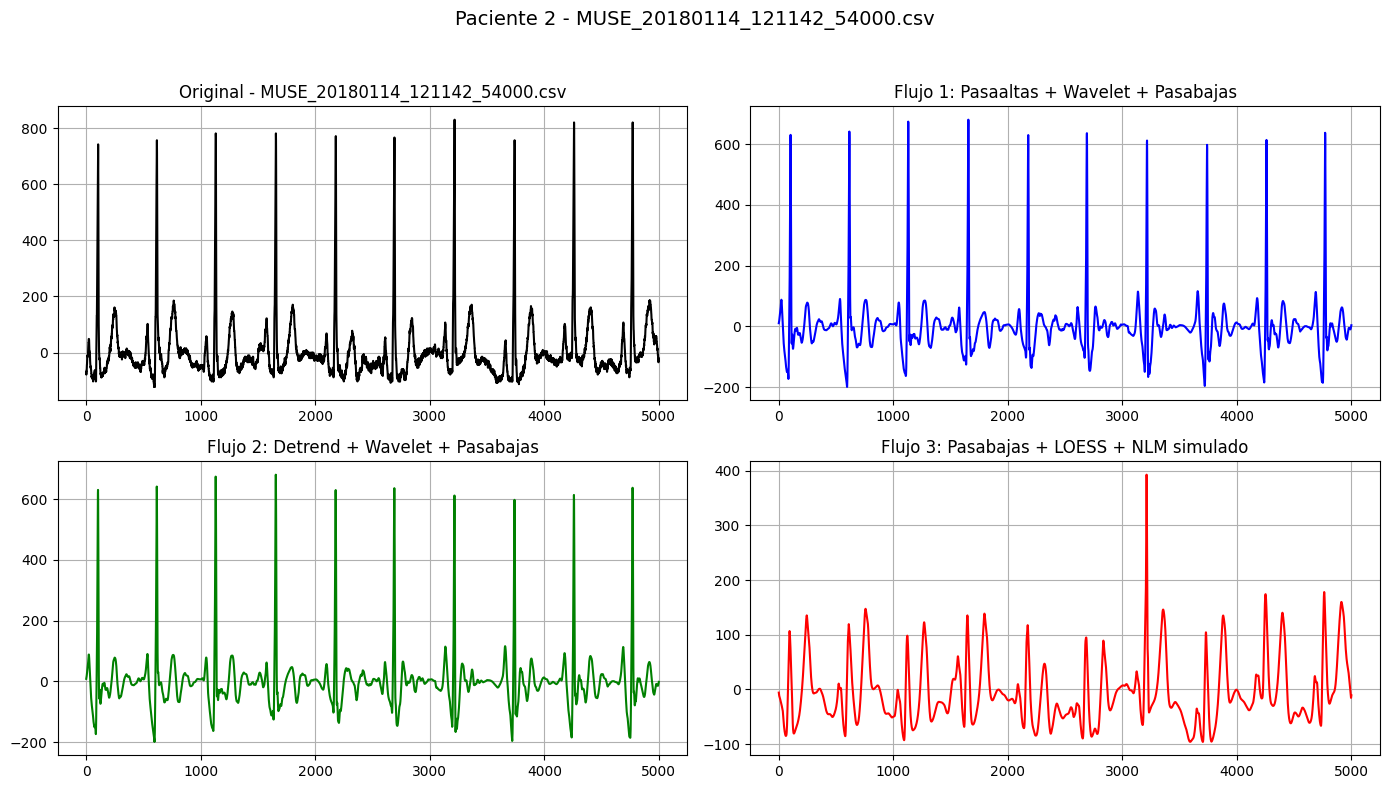

MUSE_20180712_151451_06000.csv - len(f3): 5000, NaNs: 0, min: -225.1090598813002, max: 209.12255292463993


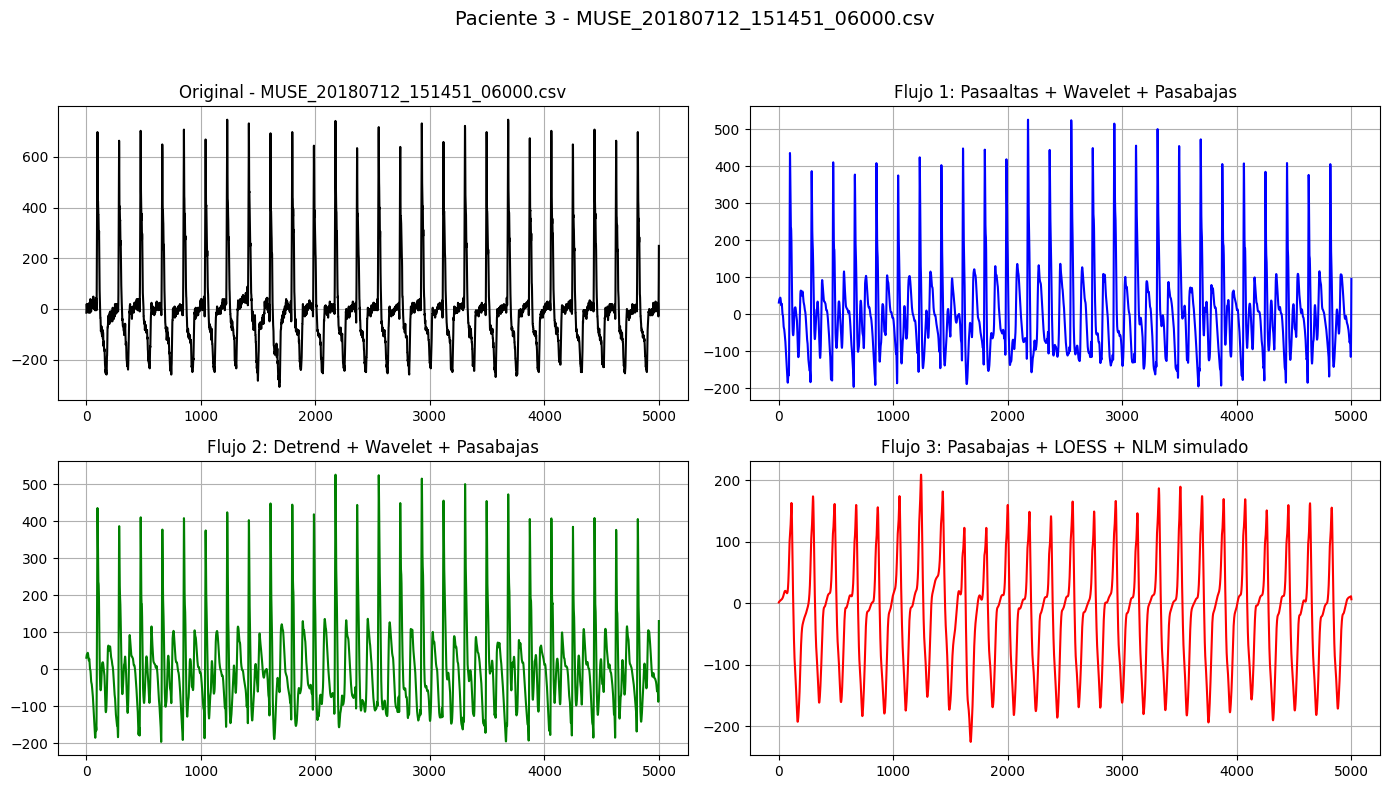

MUSE_20180114_072329_74000.csv - len(f3): 5000, NaNs: 0, min: -181.93810681737227, max: 274.97306365911265


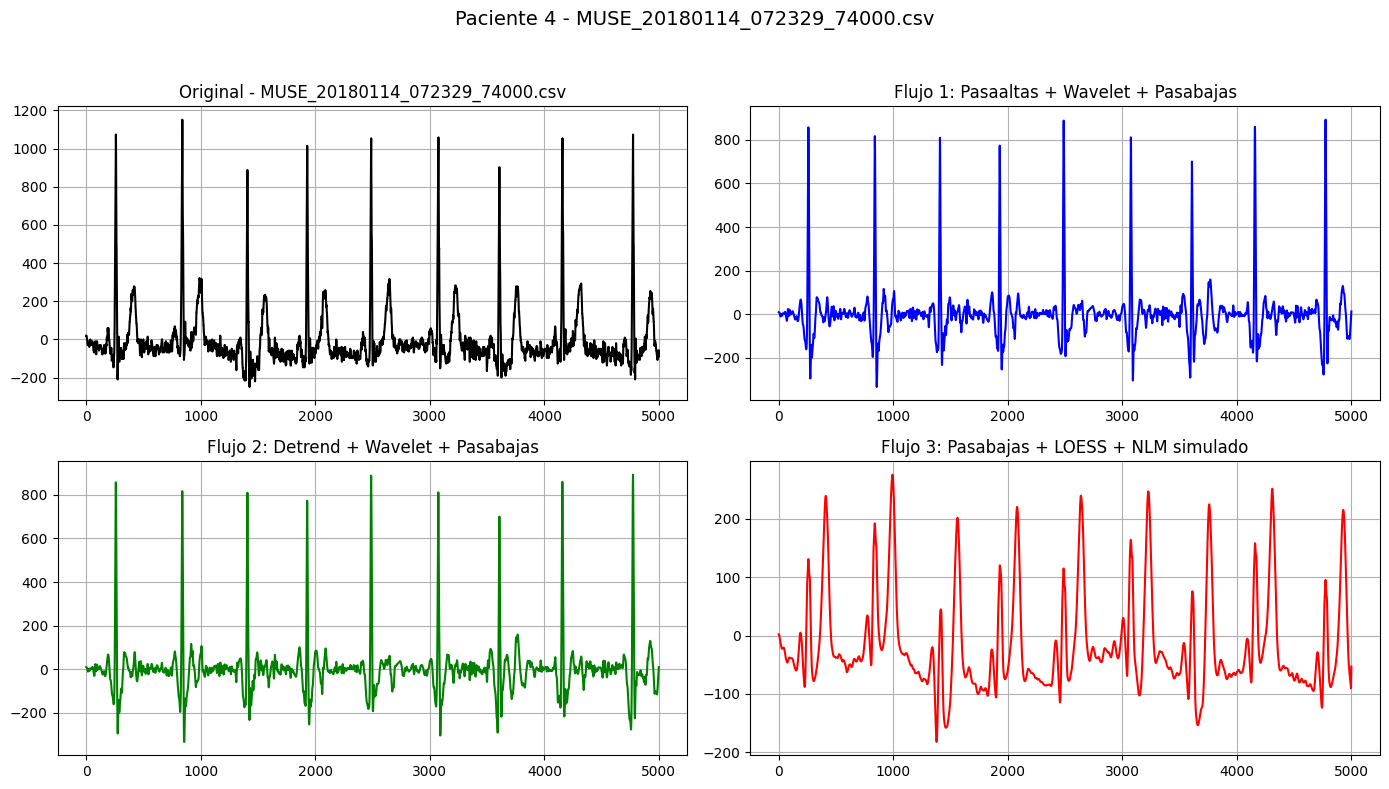

MUSE_20180209_171534_23000.csv - len(f3): 5000, NaNs: 0, min: -138.6954020665279, max: 223.69825956120587


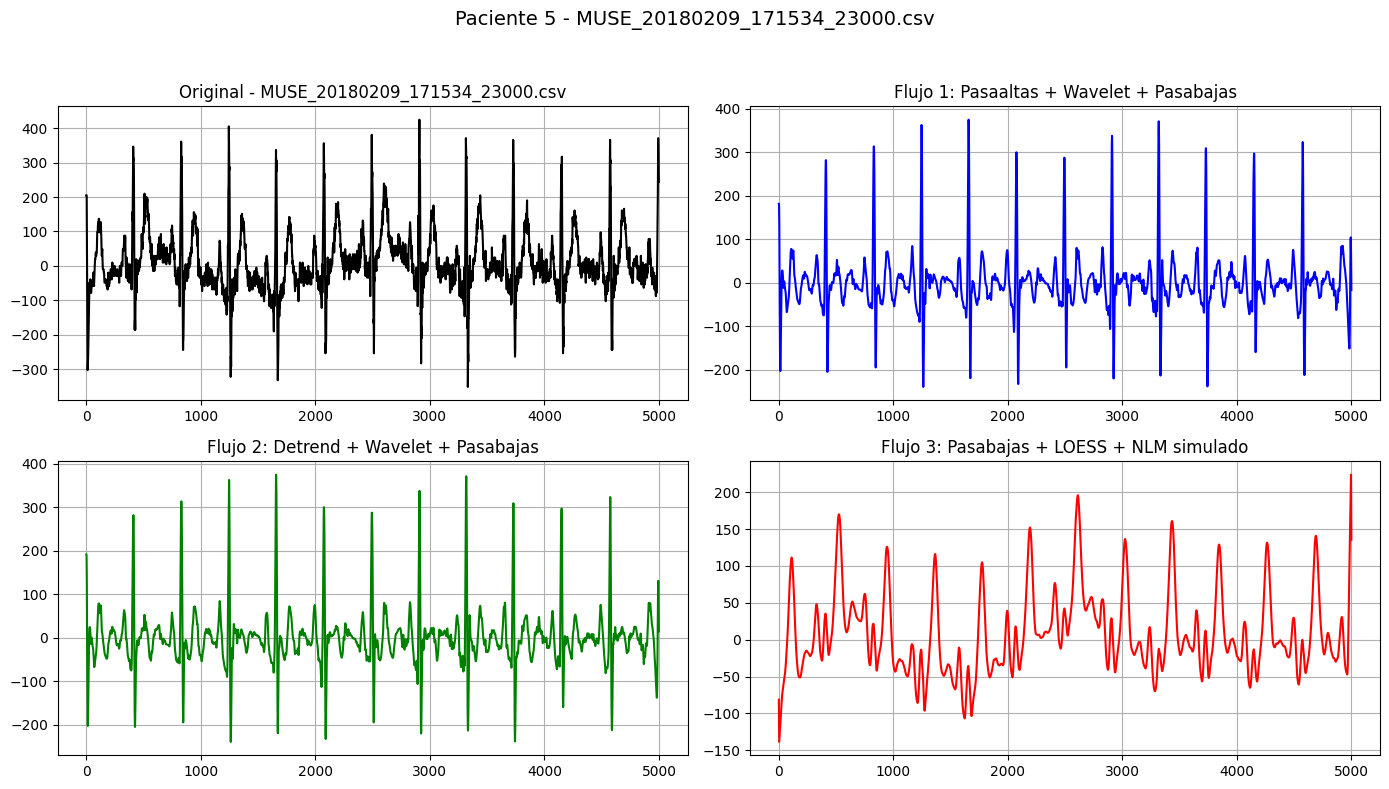

MUSE_20180111_165639_72000.csv - len(f3): 5000, NaNs: 0, min: -151.0354507986211, max: 177.1205797846814


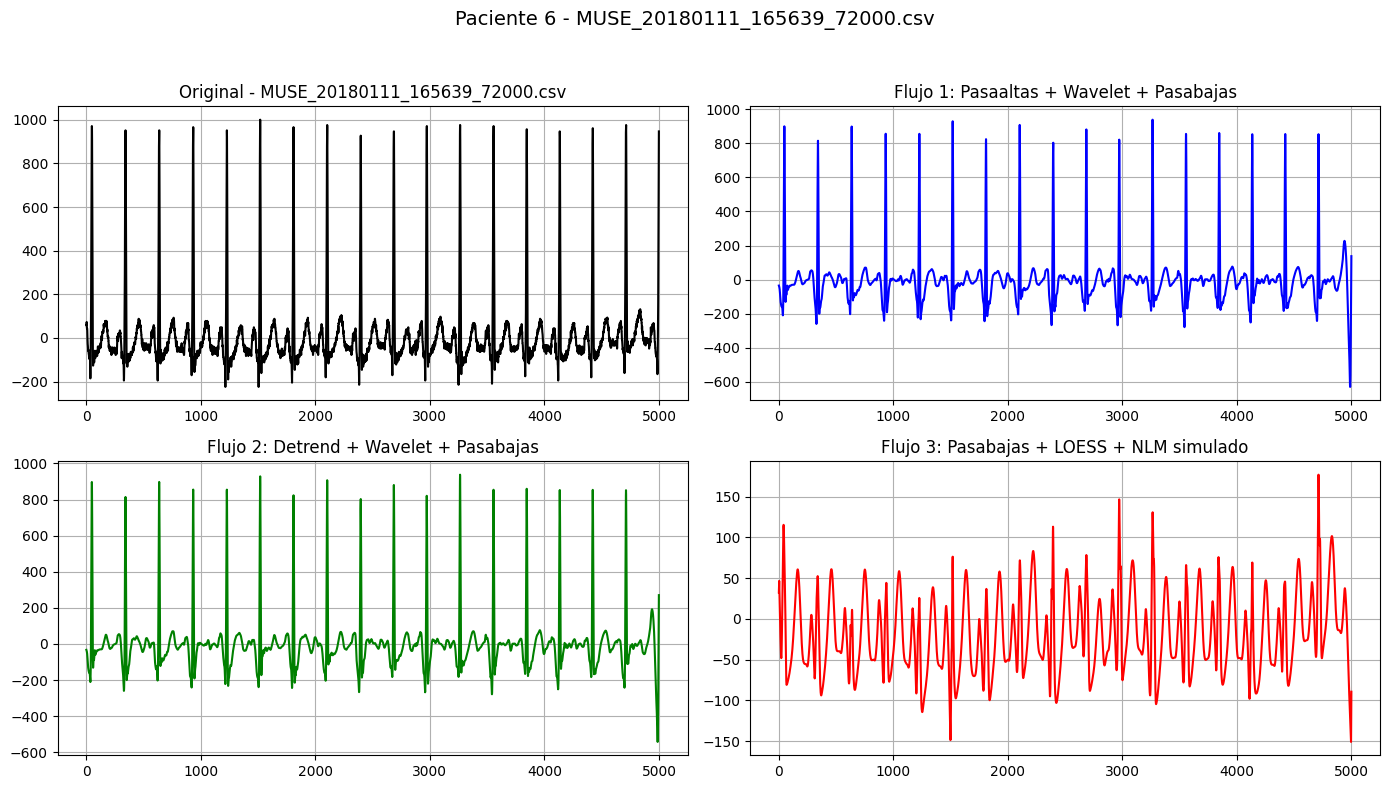

MUSE_20180210_115759_28000.csv - len(f3): 5000, NaNs: 0, min: -141.44836364823686, max: 343.90953540638037


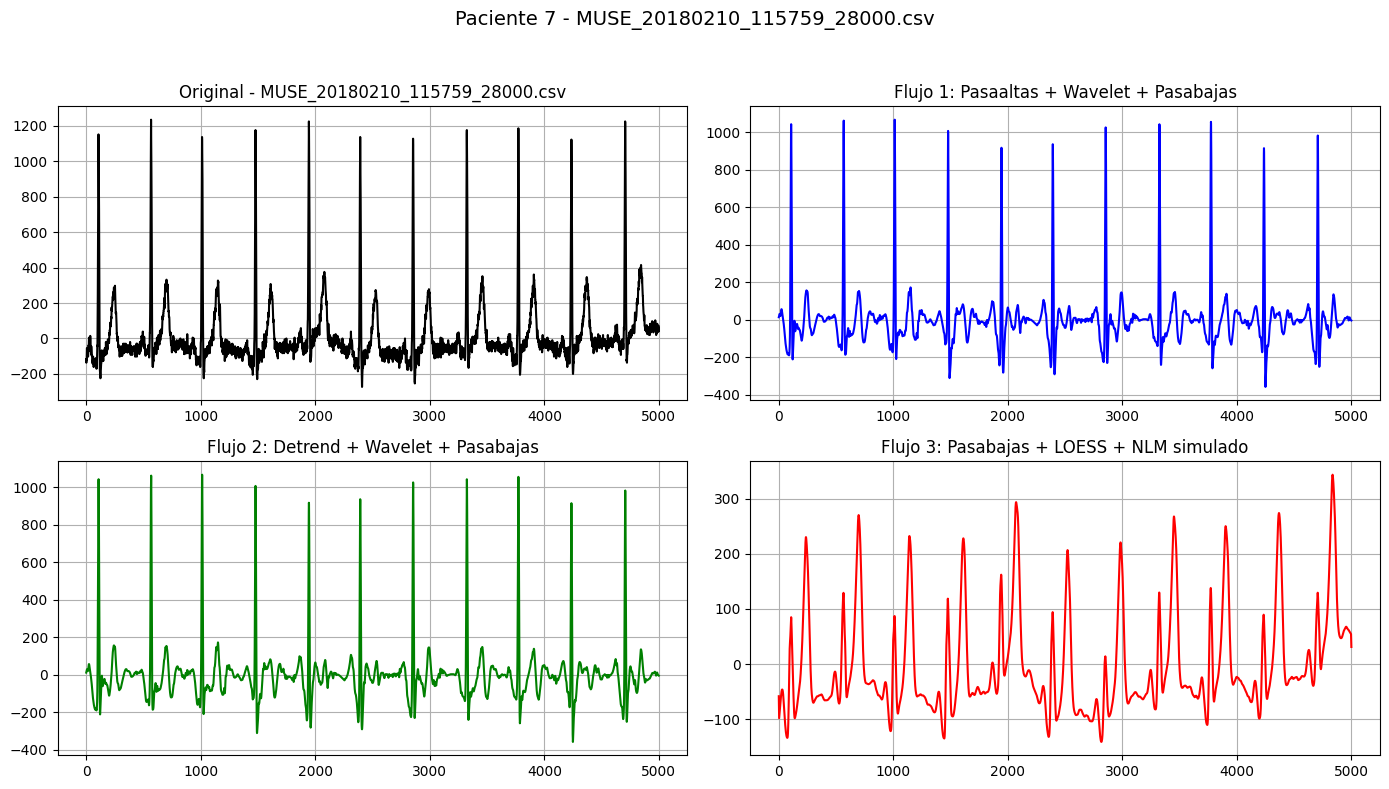

MUSE_20180114_074926_01000.csv - len(f3): 5000, NaNs: 0, min: -451.16555294231955, max: 928.7415519003348


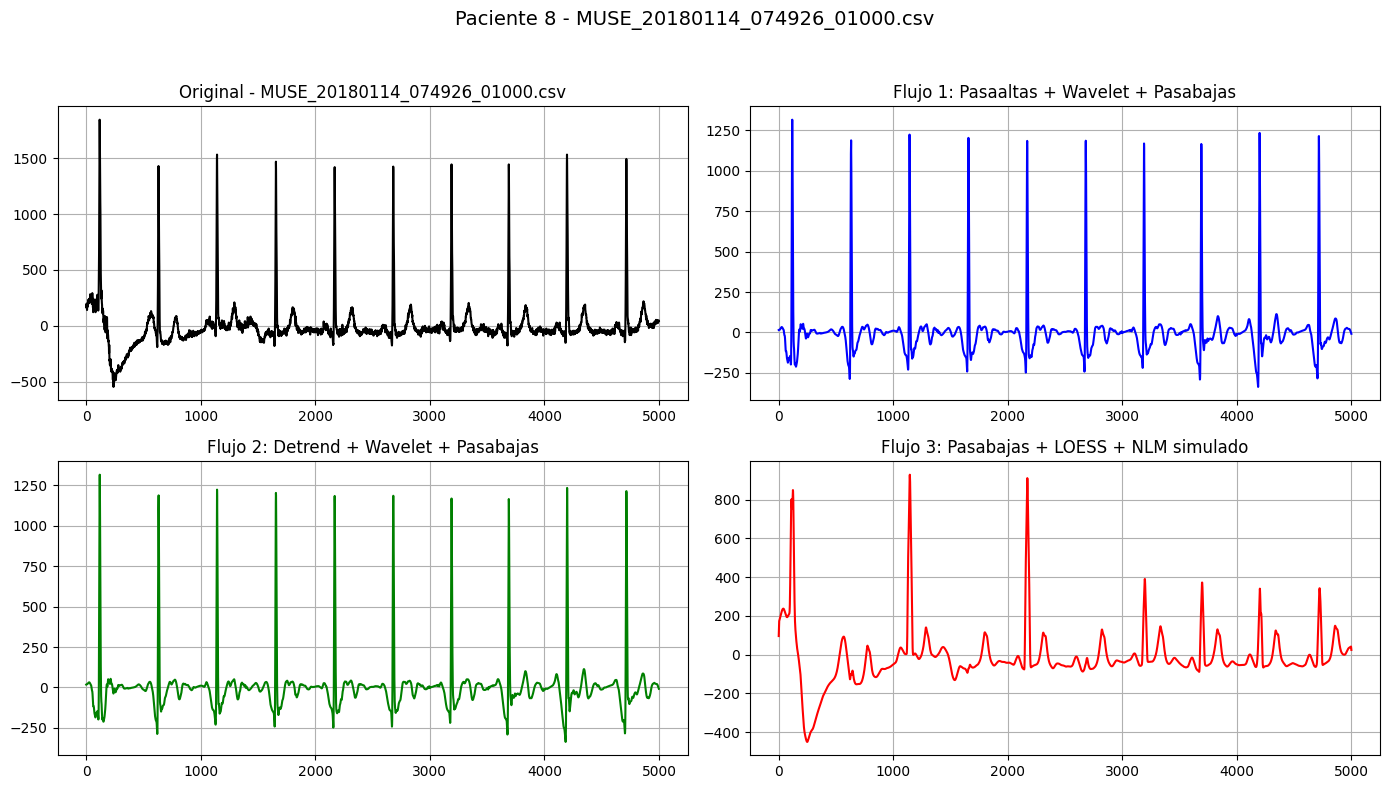

MUSE_20180113_130048_24000.csv - len(f3): 5000, NaNs: 0, min: -147.2687258821089, max: 149.01663212561482


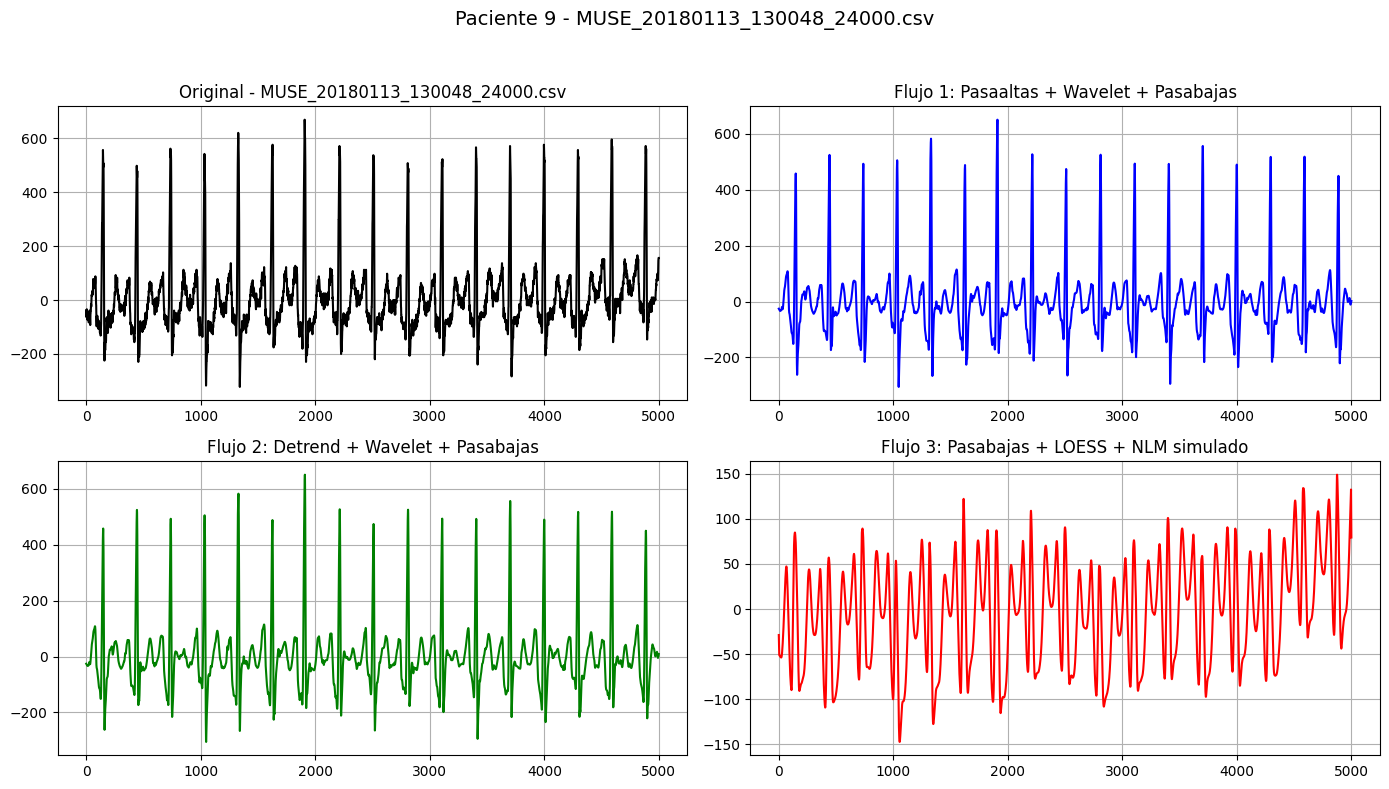

MUSE_20180120_122216_77000.csv - len(f3): 5000, NaNs: 0, min: -142.40869906787248, max: 386.44882017673496


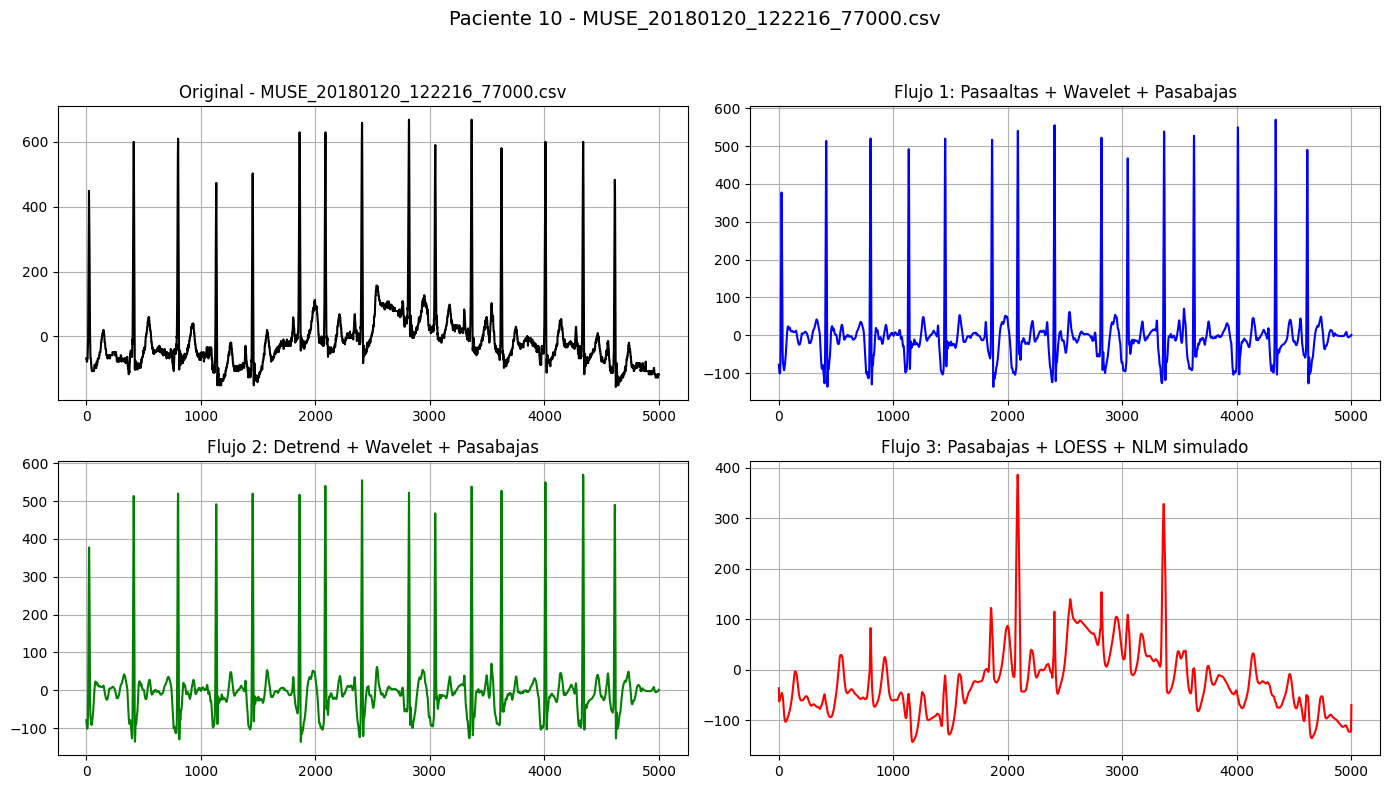

In [ ]:
def calcular_fMP(signal, fs=500):
    # Robustez: chequea que la señal sea válida
    if signal is None or len(signal) == 0 or np.all(np.isnan(signal)):
        return np.nan
    f, Pxx = welch(signal, fs)
    if len(Pxx) == 0:
        return np.nan
    return f[np.argmax(Pxx)]

resultados = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)

    # Aplicar flujos (¡robustos!)
    f1 = flujo1(ecg)
    f2 = flujo2(ecg)
    f3 = flujo3(ecg)
    
    # Diagnóstico para f3 (puedes comentar después de probar)
    print(f"{nombre} - len(f3): {len(f3)}, NaNs: {np.isnan(f3).sum()}, min: {np.nanmin(f3)}, max: {np.nanmax(f3)}")
    
    # Calcular fMP
    fmp1 = calcular_fMP(f1)
    fmp2 = calcular_fMP(f2)
    fmp3 = calcular_fMP(f3)
    resultados.append((nombre, estado, fmp1, fmp2, fmp3))
    
    # Graficar
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(ecg, color='black')
    plt.title(f"Original - {nombre}")
    plt.grid(True)
    plt.subplot(2, 2, 2)
    plt.plot(f1, color='blue')
    plt.title("Flujo 1: Pasaaltas + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 3)
    plt.plot(f2, color='green')
    plt.title("Flujo 2: Detrend + Wavelet + Pasabajas")
    plt.grid(True)
    plt.subplot(2, 2, 4)
    plt.plot(f3, color='red')
    plt.title("Flujo 3: Pasabajas + LOESS + NLM simulado")
    plt.grid(True)
    plt.suptitle(f"Paciente {i+1} - {nombre}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
df_resultados = pd.DataFrame(resultados, columns=["Registro", "Estado", "fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"])
display(df_resultados)

df_resultados.to_csv("resultados_flujos.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujos.csv'")

,Registro,Estado,fMP_Flujo1,fMP_Flujo2,fMP_Flujo3
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500,7.812500,1.953125
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375,5.859375,3.906250
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375,5.859375,1.953125
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500,7.812500,1.953125
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500,7.812500,1.953125
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625,9.765625,3.906250
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500,7.812500,1.953125
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375,5.859375,3.906250
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375,5.859375,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500,7.812500,3.906250


✔ Resultados guardados como 'resultados_flujos.csv'


Media y desviación estándar de fMP por flujo:
fMP_Flujo1: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo2: media=7.23, std=1.32, min=5.86, max=9.77
fMP_Flujo3: media=3.12, std=1.37, min=1.95, max=5.86

Valores atípicos (fuera de 1.5 * IQR):
fMP_Flujo1: 0 valores atípicos.
fMP_Flujo2: 0 valores atípicos.
fMP_Flujo3: 0 valores atípicos.


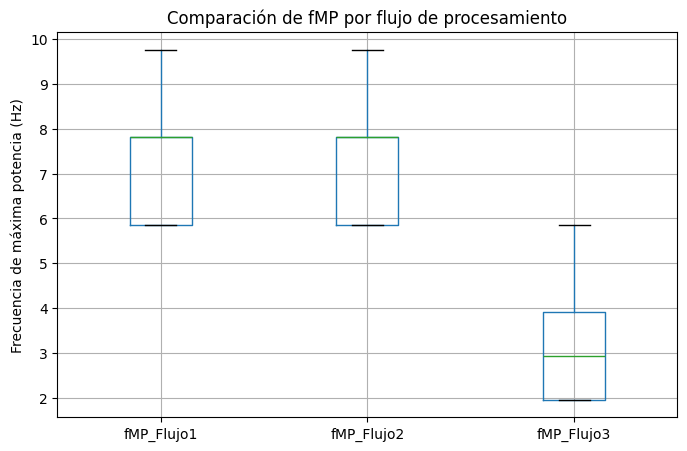

In [ ]:

# Estadística descriptiva
print("Media y desviación estándar de fMP por flujo:")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    media = df_resultados[col].mean()
    std = df_resultados[col].std()
    min_ = df_resultados[col].min()
    max_ = df_resultados[col].max()
    print(f"{col}: media={media:.2f}, std={std:.2f}, min={min_:.2f}, max={max_:.2f}")

# Detección de valores atípicos (outliers simples)
print("\nValores atípicos (fuera de 1.5 * IQR):")
for col in ["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]:
    Q1 = df_resultados[col].quantile(0.25)
    Q3 = df_resultados[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_resultados[(df_resultados[col] < Q1 - 1.5*IQR) | (df_resultados[col] > Q3 + 1.5*IQR)][col]
    print(f"{col}: {len(outliers)} valores atípicos.")

# Boxplot para comparar flujos
plt.figure(figsize=(8,5))
df_resultados[["fMP_Flujo1", "fMP_Flujo2", "fMP_Flujo3"]].boxplot()
plt.ylabel("Frecuencia de máxima potencia (Hz)")
plt.title("Comparación de fMP por flujo de procesamiento")
plt.grid(True)
plt.show()


Con base en la comparación visual del boxplot, el Flujo 1 es el más adecuado para el procesamiento de las señales ECG. Presenta valores de frecuencia de máxima potencia (fMP) dentro de un rango fisiológico esperado, similar al Flujo 2 pero con menor dispersión. Por el contrario, el Flujo 3 tiende a producir valores considerablemente menores, lo que sugiere un exceso de suavizado y posible pérdida de información relevante de la señal. Por ello, para el resto del trabajo se selecciona el Flujo 1, que garantiza una mejor preservación de las características espectrales y morfológicas del ECG.

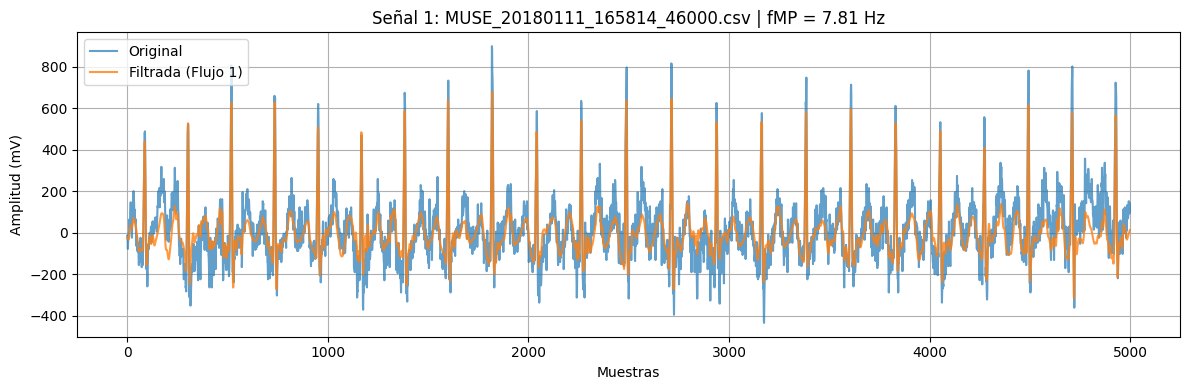

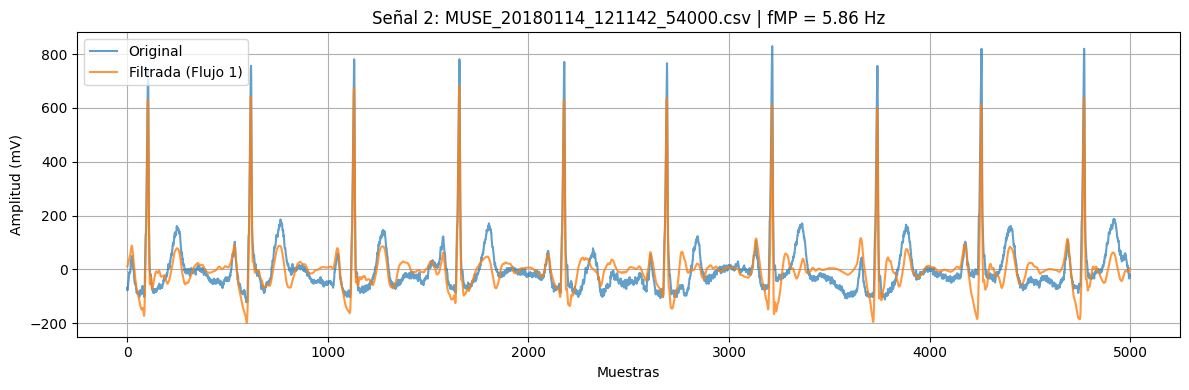

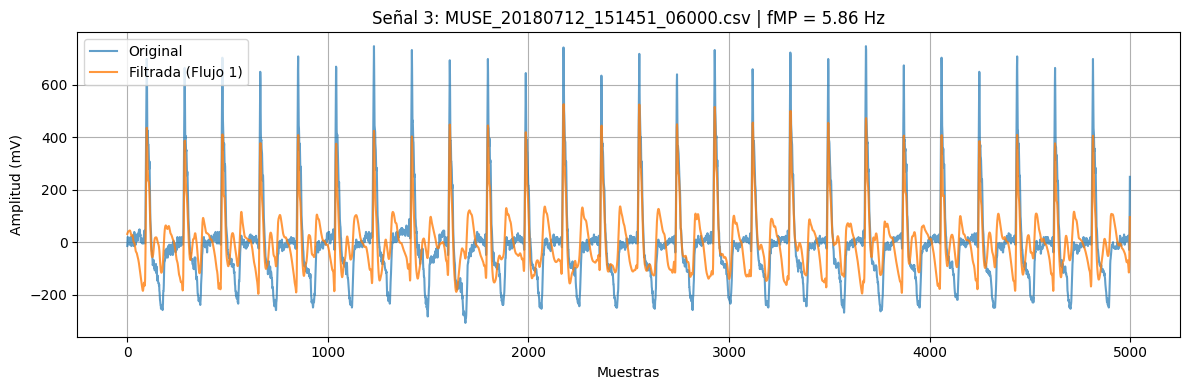

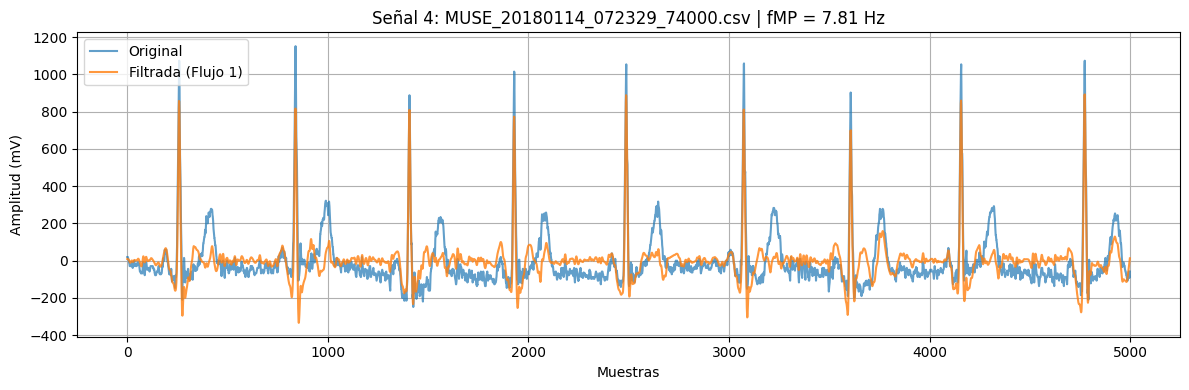

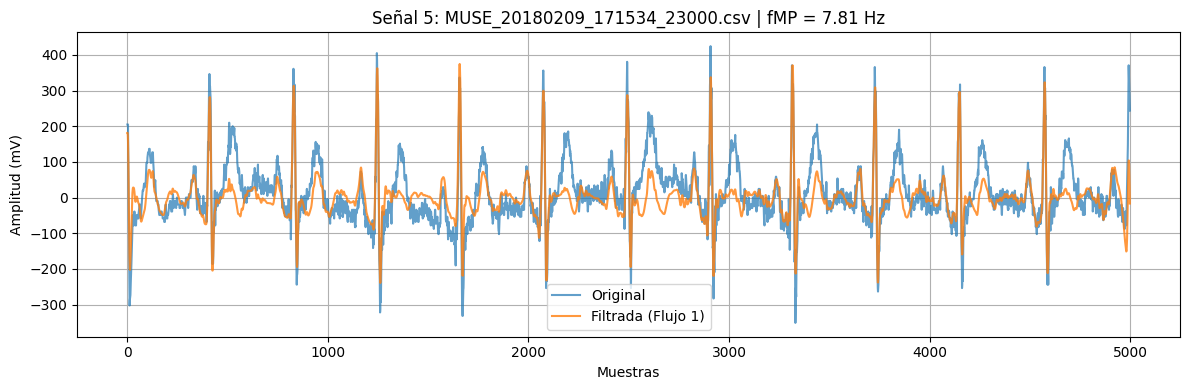

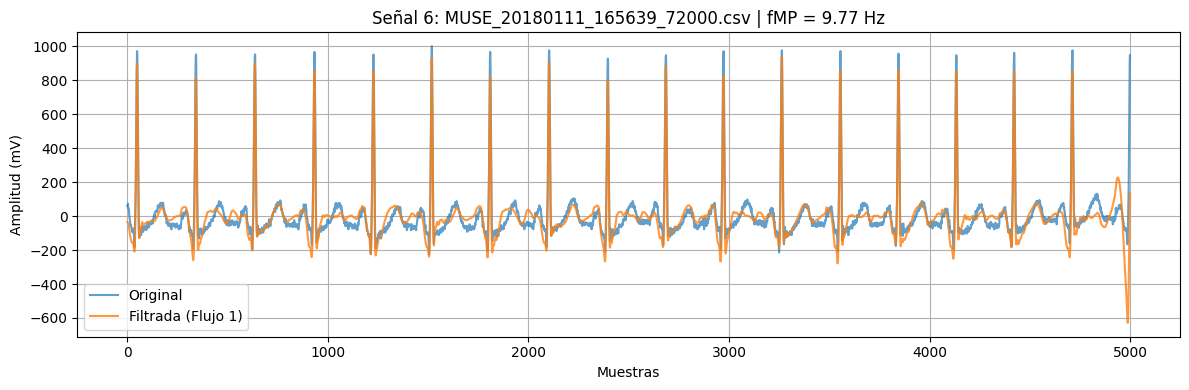

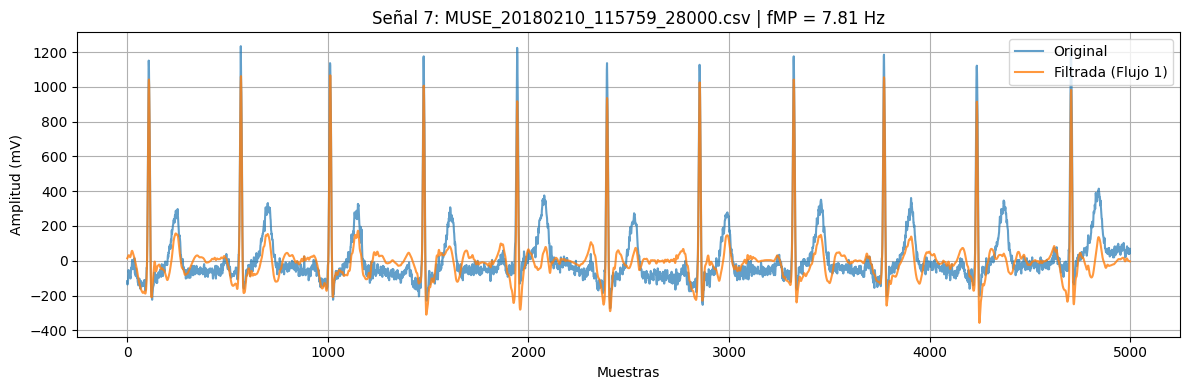

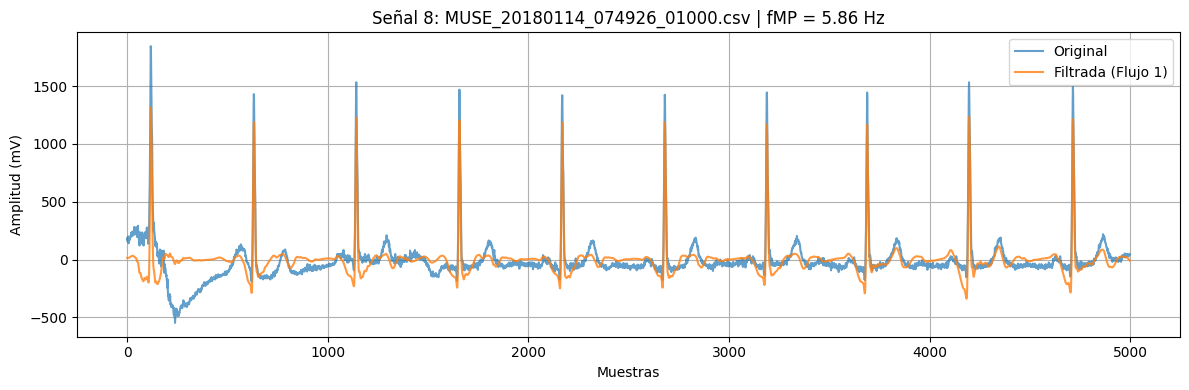

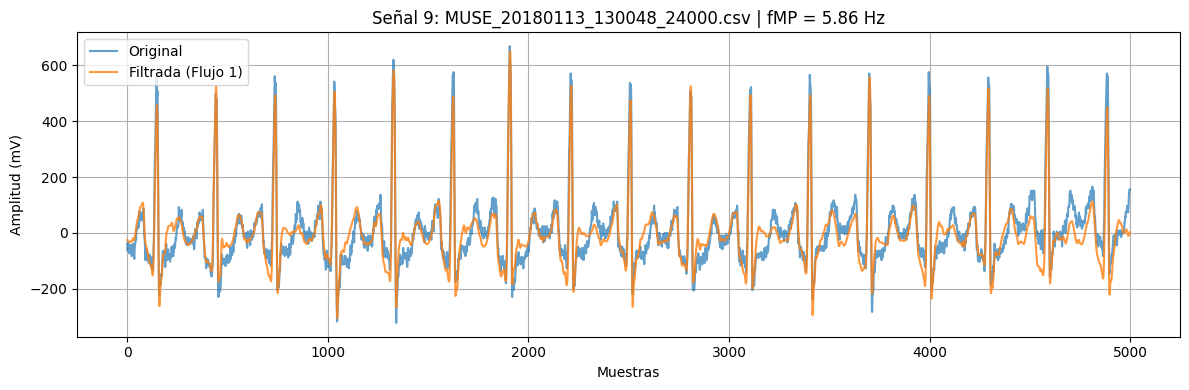

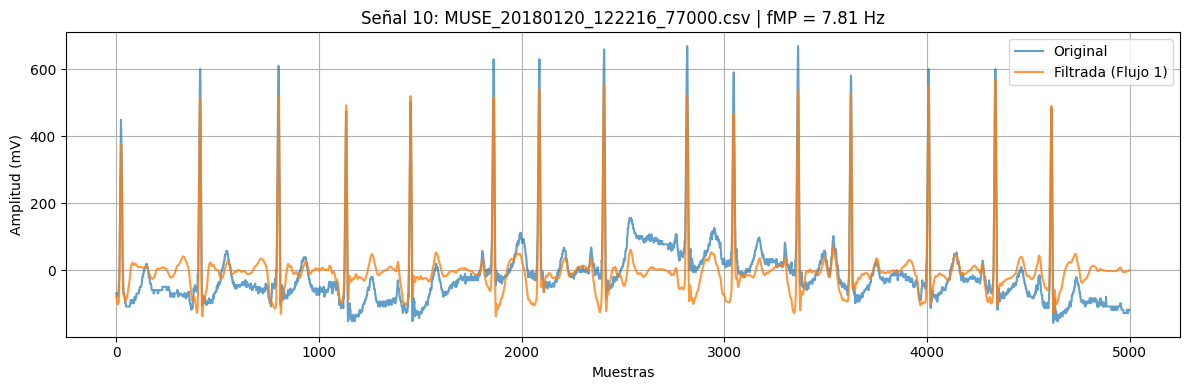

,Registro,Estado,fMP
0,MUSE_20180111_165814_46000.csv,MUSE,7.812500
1,MUSE_20180114_121142_54000.csv,MUSE,5.859375
2,MUSE_20180712_151451_06000.csv,MUSE,5.859375
3,MUSE_20180114_072329_74000.csv,MUSE,7.812500
4,MUSE_20180209_171534_23000.csv,MUSE,7.812500
5,MUSE_20180111_165639_72000.csv,MUSE,9.765625
6,MUSE_20180210_115759_28000.csv,MUSE,7.812500
7,MUSE_20180114_074926_01000.csv,MUSE,5.859375
8,MUSE_20180113_130048_24000.csv,MUSE,5.859375
9,MUSE_20180120_122216_77000.csv,MUSE,7.812500


✔ Resultados guardados como 'resultados_flujo1.csv'


In [ ]:
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    # Procesar con Flujo 1
    ecg_filtrada = flujo1(ecg)
    
    # Calcular frecuencia de máxima potencia
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))
    
    # Graficar original y filtrada
    plt.figure(figsize=(12, 4))
    plt.plot(ecg, label="Original", alpha=0.7)
    plt.plot(ecg_filtrada, label="Filtrada (Flujo 1)", alpha=0.8)
    plt.title(f"Señal {i+1}: {nombre} | fMP = {fmp:.2f} Hz")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud (mV)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Guardar resultados
df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])
display(df_flujo1)

df_flujo1.to_csv("resultados_flujo1.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1.csv'")


In [ ]:
# Asumiendo que ya tienes tu DataFrame de diagnóstico:
df_diag = pd.read_excel("Diagnostics.xlsx")  # Ajusta el nombre si es distinto

# Procesar las 10 señales seleccionadas
resultados_flujo1 = []

for i, archivo in enumerate(archivos_10):
    nombre = archivo.split('/')[-1] if '/' in archivo else archivo.split('\\')[-1]
    estado = nombre.split('_')[0]
    ecg = cargar_derivacion_II(archivo)
    
    ecg_filtrada = flujo1(ecg)
    fmp = calcular_fMP(ecg_filtrada)
    resultados_flujo1.append((nombre, estado, fmp))

df_flujo1 = pd.DataFrame(resultados_flujo1, columns=["Registro", "Estado", "fMP"])

# Unir con la columna de diagnóstico
df_flujo1 = df_flujo1.merge(df_diag, on="Registro", how="left")
df_flujo1 = df_flujo1.rename(columns={"Diagnóstico": "Tipo de patología"})  # Cambia si tu Excel usa otro nombre

display(df_flujo1)
df_flujo1.to_csv("resultados_flujo1_10senales.csv", index=False)
print("✔ Resultados guardados como 'resultados_flujo1_10senales.csv'")